In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, MaxPooling2D

from PIL import Image
from io import BytesIO
import base64
from IPython.core.display import display, HTML

import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

import seaborn as sns
from sklearn.metrics import f1_score


from tensorflow.keras.utils import img_to_array, load_img
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BASIC_PATH = "/content/drive/MyDrive/AI_Dataset/"
IMG_PATH = os.path.join(BASIC_PATH,'img_align_celeba/img_align_celeba/') # PURE IMAGE
LIST_ATTR_PATH = os.path.join(BASIC_PATH,'list_attr_celeba.csv') # Fiture Male

DF_ATTR = pd.read_csv(BASIC_PATH + 'list_attr_celeba.csv', delimiter=',')
print(IMG_PATH, LIST_ATTR_PATH)
DF_ATTR.head()

/content/drive/MyDrive/AI_Dataset/img_align_celeba/img_align_celeba/ /content/drive/MyDrive/AI_Dataset/list_attr_celeba.csv


,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [ ]:
DF_PARTITION = pd.read_csv(BASIC_PATH + 'list_eval_partition.csv') # Attribut  -> Gambar


In [ ]:
DF_ATTR.set_index('image_id', inplace=True)
DF_ATTR.replace(to_replace=-1, value=0, inplace=True) #replace -1 by 0
DF_ATTR.shape

(202599, 40)

In [ ]:
DF_PARTITION['partition'].value_counts().sort_index()

0    162770
1     19867
2     19962
Name: partition, dtype: int64

In [ ]:
# join the partition with the attributes
DF_PARTITION.set_index('image_id', inplace=True)
DF_PARTITION = DF_PARTITION.join(DF_ATTR['Male'], how='inner')
DF_PARTITION.head()

,partition,Male
image_id,,
000001.jpg,0,0
000002.jpg,0,0
000003.jpg,0,1
000004.jpg,0,0
000005.jpg,0,0


In [ ]:
#ATTRIBUTES

# Read the attributes csv files in a dataframe format.
df = pd.read_csv(LIST_ATTR_PATH, usecols=['image_id','Male'])
df = df.sample(n=2500, random_state = 42).reset_index(drop=True)

# Reset the columns values to categorical./
df.loc[df['Male'] == -1,'Male'] = "Female"
df.loc[df['Male'] == 1,'Male'] = "Male"

# Change column names.
df.columns = ["image_id", "Gender"]

df.head(-10)

,image_id,Gender
0,093242.jpg,Male
1,121414.jpg,Female
2,010625.jpg,Male
3,082524.jpg,Female
4,073193.jpg,Female
...,...,...
2485,181963.jpg,Female
2486,156956.jpg,Female
2487,092708.jpg,Male
2488,039176.jpg,Female


error: ignored

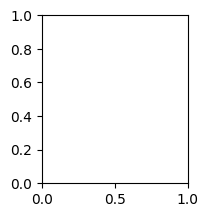

In [ ]:
# Display Multiple Sample Images.
for i in range(0, 6):
    plt.subplot(2, 3, i+1)

    # Read an Image.
    img = cv2.imread(IMG_PATH + '/' + df["image_id"][i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display Image.
    plt.imshow(img)
    plt.title(img.shape)
    plt.axis('off')

plt.tight_layout()
plt.show()

# ( 160,160.3)

In [ ]:
# Get the category distribution.
category_count = df["Gender"].value_counts()
print(category_count)

higher_category = list(category_count.index)[0]

Female    1442
Male      1058
Name: Gender, dtype: int64


In [ ]:
# Get the indices of the higher category indices images.
np.random.seed(42)
indices = df[df["Gender"] == higher_category].index
sample_size = category_count[0] - category_count[1]

# Drop the extra rows of female images to fix class imbalance problem.
drop_sample = np.random.choice(indices, sample_size, replace = False)
df = df.drop(drop_sample, axis = "index")

<Axes: >

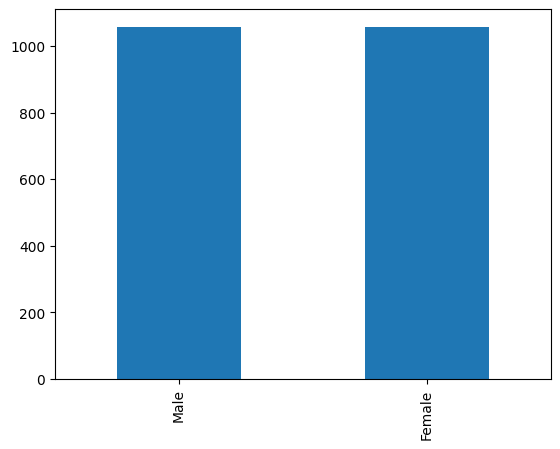

In [ ]:
df["Gender"].value_counts().plot.bar()

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2)
test_df, validation_df = train_test_split(test_df, test_size=0.33)

In [ ]:
print("Total Train Sample Images : ", len(train_df))
print("Total Test Sample Images : ", len(test_df))
print("Total Validation Sample Images : ", len(validation_df))

Total Train Sample Images :  1692
Total Test Sample Images :  284
Total Validation Sample Images :  140


In [ ]:
IMAGE_SIZE = (218, 178)
BATCH_SIZE = 16
'''seed=1337
input_shape=(64, 64, 3)
seed=1337
adam = 0.001
fre= -20
FC = 2048
E = 1
patience = 3
verbose = 1
factor = 0.50
min_lr = 0.0001
steps_per_epoch=50
validation_steps=50
epochs=8'''

'seed=1337\ninput_shape=(64, 64, 3)\nseed=1337\nadam = 0.001\nfre= -20\nFC = 2048\nE = 1\npatience = 3\nverbose = 1\nfactor = 0.50\nmin_lr = 0.0001\nsteps_per_epoch=50\nvalidation_steps=50\nepochs=8'

In [ ]:
# Generate Train Images Data Generator.
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    IMG_PATH + "/",
    x_col='image_id',
    y_col='Gender',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    #seed=seed,
    batch_size=BATCH_SIZE
)


Found 0 validated image filenames belonging to 0 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1692 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
# Generate Validation Images Data Generator.
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validation_df,
    IMG_PATH + "/",
    x_col='image_id',
    y_col='Gender',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    #seed=seed,
    batch_size=BATCH_SIZE
)

Found 0 validated image filenames belonging to 0 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 140 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df,
    IMG_PATH + "/",
    x_col='image_id',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    #seed=seed,
    shuffle=False
)

Found 0 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 284 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
import numpy as np
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D

base_model = VGG16(weights='imagenet', include_top=False, input_shape=IMAGE_SIZE + (3,))
#base_model = tf.keras.applications.VGG16(input_shape=input_shape,include_top=False,weights="imagenet")


58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 218, 178, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 218, 178, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 218, 178, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 109, 89, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 109, 89, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 109, 89, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 54, 44, 128)       0     

In [ ]:
# Building Model
model=Sequential()
model.add(base_model)
#model.add(layers.Dropout(.2))

model.add(Conv2D(512, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.1))
model.add(Conv2D(256, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.1))
model.add(Conv2D(128, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.1))
model.add(Conv2D(64, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.1))
model.add(Conv2D(32, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(16, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(8, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(4, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,strides=(2,2), padding='same'))

# Add new layers
model.add(Flatten())
model.add(Dense(256 , activation='relu'))
model.add(layers.Dropout(.2))
model.add(Dense(256 , activation='relu'))
model.add(layers.Dropout(.2))
model.add(Dense(64, activation='relu'))
model.add(layers.Dropout(.2))
model.add(Dense(32, activation='relu'))
model.add(layers.Dropout(.2))
model.add(Dense(32, activation='relu'))
model.add(layers.Dropout(.2))
model.add(Dense(2, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 5, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 6, 5, 512)         2359808   
                                                                 
 batch_normalization (BatchN  (None, 6, 5, 512)        2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 6, 5, 512)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 5, 256)         1179904   
                                                                 
 batch_normalization_1 (Batc  (None, 6, 5, 256)        1024      
 hNormalization)                                        

In [ ]:
'''model = Sequential(
    [
    base_model, #mobilenet
    Flatten(),
    Dense(256,activation='relu'),
    Dense(256,activation='relu'),
    Dense(64,activation='relu'),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='sigmoid')
]
)

x = base_model.output
predictions = Dense(2, activation='sigmoid') (x)'''

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 5, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 6, 5, 512)         2359808   
                                                                 
 batch_normalization (BatchN  (None, 6, 5, 512)        2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 6, 5, 512)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 5, 256)         1179904   
                                                                 
 batch_normalization_1 (Batc  (None, 6, 5, 256)        1024      
 hNormalization)                                        

In [ ]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='model1.hdf5', # load
                               verbose=1, save_best_only=True)

In [ ]:
patience = 4
verbose = 1
factor = 0.5
min_lr = 0.0001

earlystop = EarlyStopping(patience=10)
lrd = ReduceLROnPlateau(monitor = 'val_accuracy',
                        patience = patience,
                        verbose = verbose ,
                        factor = factor,
                        min_lr = min_lr)

#mcp = ModelCheckpoint('model.h5')

#callbacks = EarlyStopping(verbose=verbose, patience=patience)

callbacks = [earlystop, lrd, checkpointer]

In [ ]:
history = model.fit(train_generator, validation_data = validation_generator
                        , validation_steps=len(validation_df)//BATCH_SIZE
                        ,steps_per_epoch=len(train_df)//BATCH_SIZE,
                        epochs=10, verbose = 1, callbacks=callbacks)


ValueError: ignored

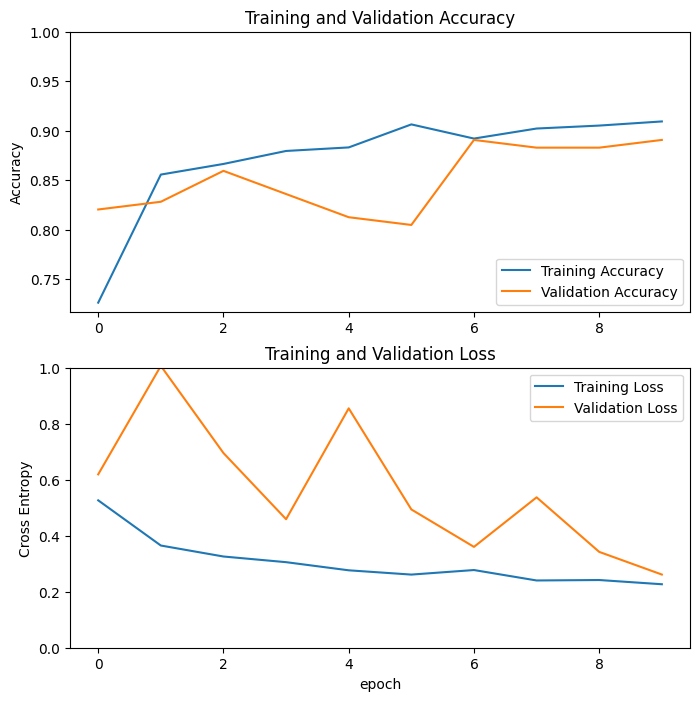

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model.load_weights('model1.hdf5')

In [ ]:
predict = model.predict(test_generator, steps=np.ceil(len(test_df)/BATCH_SIZE))

18/18 [==============================] - 1s 54ms/step


In [ ]:
prediction = predict.argmax(axis=-1)
test_df['Prediction'] = ["Male" if ele == 1 else "Female" for ele in prediction]

In [ ]:
test_df

,image_id,Gender,Prediction
119,071160.jpg,Female,Female
2406,162337.jpg,Female,Female
914,060475.jpg,Male,Male
1230,102227.jpg,Male,Female
976,148106.jpg,Male,Male
...,...,...,...
1461,107642.jpg,Female,Female
780,187640.jpg,Male,Male
612,152534.jpg,Male,Male
2334,140047.jpg,Male,Male


In [ ]:
labels = ['Male','Female']

cm = confusion_matrix(test_df['Gender'], test_df["Prediction"], labels= labels)
cm

array([[124,  12],
       [ 10, 138]], dtype=int64)

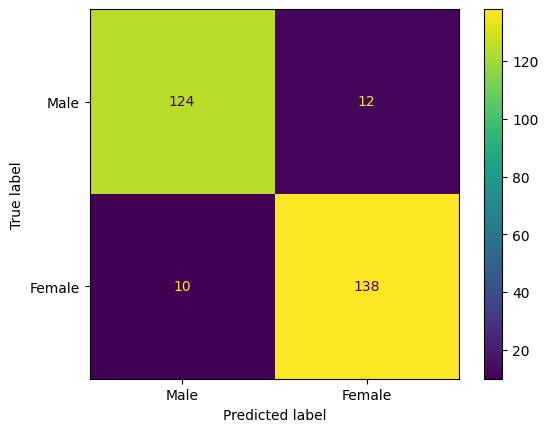

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp.plot()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

print(classification_report(test_df['Gender'], test_df["Prediction"], labels= labels))

              precision    recall  f1-score   support

        Male       0.93      0.91      0.92       136
      Female       0.92      0.93      0.93       148

    accuracy                           0.92       284
   macro avg       0.92      0.92      0.92       284
weighted avg       0.92      0.92      0.92       284



In [ ]:
gender_target = {0: 'Female', 1: 'Male'}

def img_to_display(filename):
    # inspired on this kernel:
    # https://www.kaggle.com/stassl/displaying-inline-images-in-pandas-dataframe
    # credits to stassl :)

    i = Image.open(filename)
    i.thumbnail((200, 200), Image.LANCZOS)

    with BytesIO() as buffer:
        i.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()


def display_result(filename, prediction, target):
    '''
    Display the results in HTML

    '''

    gender = 'Male'
    gender_icon = "https://i.imgur.com/nxWan2u.png"

    if prediction[1] <= 0.5:
        gender_icon = "https://i.imgur.com/oAAb8rd.png"
        gender = 'Female'

    display_html = '''
    <div style="overflow: auto;  border: 2px solid #D8D8D8;
        padding: 5px; width: 420px;" >
        <img src="data:image/jpeg;base64,{}" style="float: left;" width="200" height="200">
        <div style="padding: 10px 0px 0px 20px; overflow: auto;">
            <img src="{}" style="float: left;" width="40" height="40">
            <h3 style="margin-left: 50px; margin-top: 2px;">{}</h3>
            <p style="margin-left: 50px; margin-top: -6px; font-size: 12px">{} prob.</p>
            <p style="margin-left: 50px; margin-top: -16px; font-size: 12px">Real Target: {}</p>
            <p style="margin-left: 50px; margin-top: -16px; font-size: 12px">Filename: {}</p>
        </div>
    </div>
    '''.format(img_to_display(filename)
               , gender_icon
               , gender
               , "{0:.2f}%".format(round(max(prediction)*100,2))
               , gender_target[target]
               , filename.split('/')[-1]
               )

    display(HTML(display_html))

In [ ]:
def gender_prediction(filename):
    '''
    predict the gender

    input:
        filename: str of the file name

    return:
        array of the prob of the targets.

    '''

    im = cv2.imread(filename)
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (178, 218)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis =0)

    # prediction
    result = model.predict(im)
    prediction = np.argmax(result)

    return result

1/1 [==============================] - 0s 318ms/step



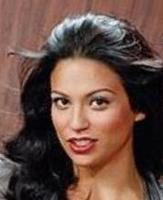

1/1 [==============================] - 0s 27ms/step



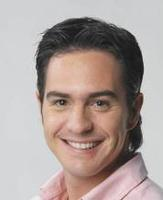

1/1 [==============================] - 0s 25ms/step



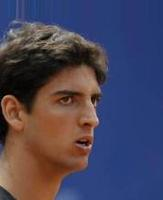

1/1 [==============================] - 0s 22ms/step



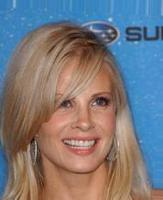

1/1 [==============================] - 0s 23ms/step



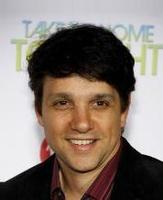

1/1 [==============================] - 0s 21ms/step



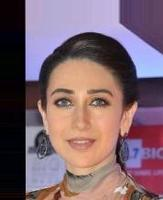

1/1 [==============================] - 0s 22ms/step



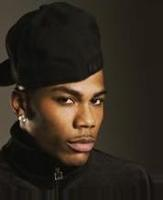

1/1 [==============================] - 0s 21ms/step



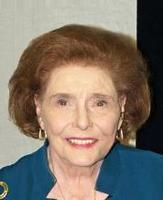

In [ ]:
df_to_test = DF_PARTITION[(DF_PARTITION['partition'] == 2)].sample(8)

for index, target in df_to_test.iterrows():
    result = gender_prediction(IMG_PATH + index)

    #display result
    display_result(IMG_PATH + index, result[0], target['Male'])